In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from src.dataset import RESTsMRIDataset, RESTfMRIDataset
from src.model import SFCNEncoder, GINEncoder


ALLOWED_SPLITS = {
    # Regex for matching all columns excluding the ones in the dev and test splits
    # using negative pattern matching
    "train": r"(?!(S4|S8|S15|S17)-).*",
    "dev": r"((S4|S8)-)",
    "test": r"((S15|S17)-)",
    "full": r".*",
}

split = "train"
cache = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metadata = pd.read_csv("REST-meta-MDD/metadata.csv")
cond = metadata.subID.str.match(ALLOWED_SPLITS[split])
metadata = metadata[cond].reset_index(drop=True)
labels = metadata['sex'].to_numpy()


/tmp/ipykernel_1357714/4164224419.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))


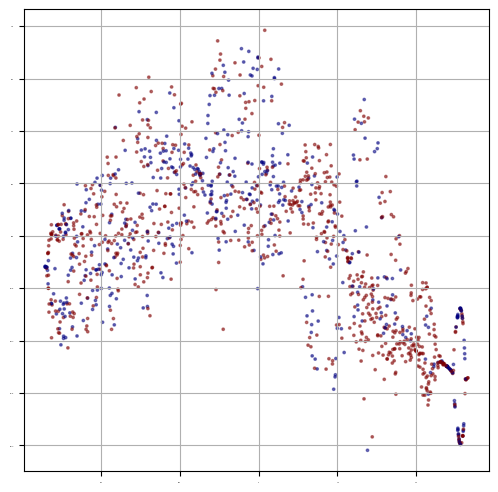

In [18]:
model_path = "models/eigenencoder_ssl_baseline/smri_enc_ep30.pt"

dset = RESTsMRIDataset(split=split)
net = SFCNEncoder(emb_dim=256).to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

if model_path not in cache:
    embs = []
    for i in range(len(dset)):
        x, _ = dset[i]
        x = x.unsqueeze(0).to(device)

        with torch.no_grad():
            emb = net(x).cpu().numpy()
            embs.append(emb)
    
    cache[model_path] = np.stack(embs, axis=0).squeeze()

embs = cache[model_path]
X_embedded = TSNE(n_components=2, perplexity=150).fit_transform(embs)

plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.5, c=labels, s=3.0, cmap='jet')
plt.grid('None')
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

/tmp/ipykernel_1357714/374066428.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))


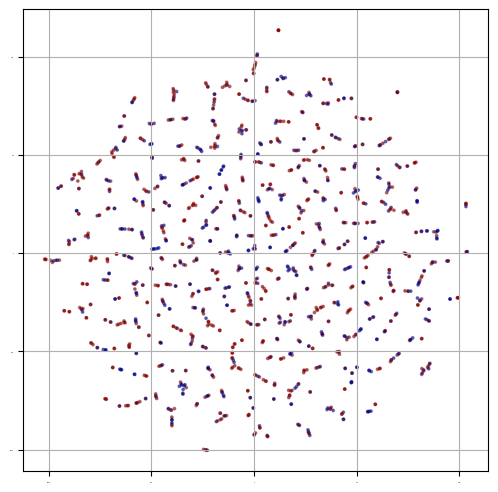

In [30]:
model_path = "models/eigenencoder_ssl_baseline/fmri_enc_ep30.pt"

dset = RESTfMRIDataset(split=split)
net = GINEncoder(
    in_channels=116, 
    hidden_channels=256, 
    num_layers=2, 
    dropout=0.5,
    norm='batch',
    emb_dim=256
    ).to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

if model_path not in cache:
    embs = []
    for i in range(len(dset)):
        data = dset[i].to(device)
        data.batch_size = 1

        with torch.no_grad():
            emb = net(data).cpu().numpy()
            embs.append(emb)
    
    cache[model_path] = np.stack(embs, axis=0).squeeze()

embs = cache[model_path]
X_embedded = TSNE(n_components=2, perplexity=2).fit_transform(embs)

plt.figure(figsize=(6, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.5, c=labels, s=3.0, cmap='jet')
plt.grid('None')
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()